# 目的
2019/01/01 00:00 - 2019/01/09 00:00の期間について、特定のパターンが現れたときのみ注文したらどうなるか確認する。

## モジュールと関数の用意

In [1]:
from datetime import datetime
import glob
import itertools
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import numpy as np
import os
import pandas as pd
import pickle
# import sys
# sys.path.append("./")
from utils import *

%matplotlib inline

In [25]:
def main(df, N1, N2, N_dec=5, patterns_golden=None, patterns_dead=None):
    """main(df, N1, N2, N_dec=5, patterns_golden=None, patterns_dead=None) -> dict
    calculate some factors
    
    Parameters
    ----------
    df              : pandas.DataFrame
    N1              : int
    N2              : int
    N_dec           : int
    patterns_golden : array-like
    patterns_dead   : array-like
    
    Returns
    -------
    results : dict
    """
    close_ = df["close"].values
    open_ = df["open"].values
    
    # calcualte EMA
    ema1 = calc_EMA(close_, N1)
    ema2 = calc_EMA(close_, N2)
    
    # find cross points
    cross_points = find_cross_points(ema1, ema2)
    ind_ = cross_points != 0
    a_k = np.vstack((np.arange(len(cross_points))[ind_], cross_points[ind_])).transpose().astype(int)
    
    # find local maxima and minima of the difference, "EMA1 - EMA2"
    ema_diff = ema1 - ema2
    maxtab_ema_diff, mintab_ema_diff = peakdet(ema_diff, 10)
    
    # symbolize
    dec = symbolize(df, N_dec)
    
    # extract factors for each godlen/dead cross points
    dec_ext = np.zeros(len(a_k), int)
    t1_ext = np.zeros(len(a_k), int)
    tm_ext = np.zeros(len(a_k), int)
    distance_ext = np.zeros(len(a_k), int)
    
    for ii in range(len(a_k)-1):
        ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
        
        v = a_k[ii][1]
        o_ = open_[ind1:ind2]
        c_ = close_[ind1:ind2]
        if v < 0: # dead cross
            if patterns_dead is None or dec[ind1] in patterns_dead:
                # start value
                if len(o_) > 1:
                    t1_ext[ii] = min(o_[1], c_[1])
                else:
                    t1_ext[ii] = min(o_[0], c_[0])

                # minimum index
                index = (mintab_ema_diff[:, 0]>=ind1)&(mintab_ema_diff[:, 0]<ind2)
                count = index.sum()
                if count > 0:
                    tm = (mintab_ema_diff[index, 0]).astype(int)[0]
                else:
                    tm = ind1
                tm_ext[ii] = max(open_[tm+1], close_[tm+1])
                distance_ext[ii] = tm - ind1 + 1
                dec_ext[ii] = dec[ind1]
        else: # golden cross
            if patterns_golden is None or dec[ind1] in patterns_golden:
                # start value
                if len(o_) > 1:
                    t1_ext[ii] = max(o_[1], c_[1])
                else:
                    t1_ext[ii] = max(o_[0], c_[0])

                # maximum index
                index = (maxtab_ema_diff[:, 0]>=ind1)&(maxtab_ema_diff[:, 0]<ind2)
                count = index.sum()
                if count > 0:
                    tm = (maxtab_ema_diff[index, 0]).astype(int)[0]
                else:
                    tm = ind1
                tm_ext[ii] = min(open_[tm+1], close_[tm+1])
                distance_ext[ii] = tm - ind1 + 1
                dec_ext[ii] = dec[ind1]
    
    # calculate benefits
    benefits = tm_ext - t1_ext
    benefits[np.abs(benefits)>1e5] = 0.0
    
    # extract statistics and value-pattern pairs
    stat_dead = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
    list_ext_dead = [np.empty(0, dtype=float)] * 2**N_dec
    for ii, ind in enumerate(dec_ext[a_k[:, 1] == -1]):
        v = benefits[a_k[:, 1] == -1][ii]
        list_ext_dead[ind] = np.append(list_ext_dead[ind], v)

    for ii in range(len(list_ext_dead)):
        arr = list_ext_dead[ii]
        if len(arr) != 0:
            ind = np.abs(arr) <=100000
            list_ext_dead[ii] = arr[ind]
            stat_dead[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

    stat_golden = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
    list_ext_golden = [np.empty(0, dtype=float)] * 2**N_dec
    for ii, ind in enumerate(dec_ext[a_k[:, 1] == 1]):
        v = benefits[a_k[:, 1] == 1][ii]
        list_ext_golden[ind] = np.append(list_ext_golden[ind], v)

    for ii in range(len(list_ext_golden)):
        arr = list_ext_golden[ii]
        if len(arr) != 0:
            ind = np.abs(arr) <=100000
            list_ext_golden[ii] = arr[ind]
            stat_golden[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])
    
    results = dict(
        ema1=ema1, ema2=ema2, cross_points=cross_points, a_k=a_k,
        dec_ext=dec_ext, distance_ext=distance_ext, benefits=benefits,
        stat_dead=stat_dead, list_ext_dead=list_ext_dead,
        stat_golden=stat_golden, list_ext_golden=list_ext_golden
    )
    return results

## データの読み込み

In [2]:
file_list = [
    "../data/ohlcv/OHLCV_201901010000_to_201901070000.csv",
    "../data/ohlcv/OHLCV_201901070001_to_201901080000.csv",
    "../data/ohlcv/OHLCV_201901080001_to_201901090000.csv",
]

df = None
for fpath in file_list:
    if df is None:
        df = pd.read_csv(fpath, index_col=0)
    else:
        df_ = pd.read_csv(fpath, index_col=0)
        df = pd.concat((df, df_))
df.head()

,time,id_start,open,high,low,close,volume
0,1.546236e+09,694426164,419209,421060,419022,419732,350
1,1.546236e+09,694427312,419898,422592,418124,419352,1000
2,1.546236e+09,694430055,419352,419727,416443,416697,779
3,1.546236e+09,694433381,416443,417700,409500,413668,2184
4,1.546236e+09,694437582,410638,417000,410612,414100,1281


In [3]:
df.tail()

,time,close,high,low,open,volumefrom,volumeto
2875,2019-01-05T11:56:00.000000,416525,416654,416500,416642,62.71,26121115.78
2876,2019-01-05T11:57:00.000000,416636,416739,416504,416525,120.99,50410334.22
2877,2019-01-05T11:58:00.000000,416716,416847,416636,416636,126.07,52540113.96
2878,2019-01-05T11:59:00.000000,416701,416750,416555,416716,74.11,30879185.11
2879,2019-01-05T12:00:00.000000,416874,416940,416686,416701,134.74,56163371.04


In [4]:
len(df)

17059

## 計算

In [21]:
import time

N_dec = 5
N1 = 20
N2 = 21

st = time.time()
results = main(df, N1, N2, N_dec)
print(time.time() - st)

0.7989482879638672


In [22]:
ema1 = results["ema1"]
ema2 = results["ema2"]
ema_diff = ema1 - ema2
cross_points = results["cross_points"]
benefits = results["benefits"]
a_k = results["a_k"]
distance = results["distance_ext"]
dec_ext = results["dec_ext"]

In [23]:
-benefits[a_k[:, 1] == -1].sum() + benefits[a_k[:, 1] == 1].sum()

127621

## 平均のプロット

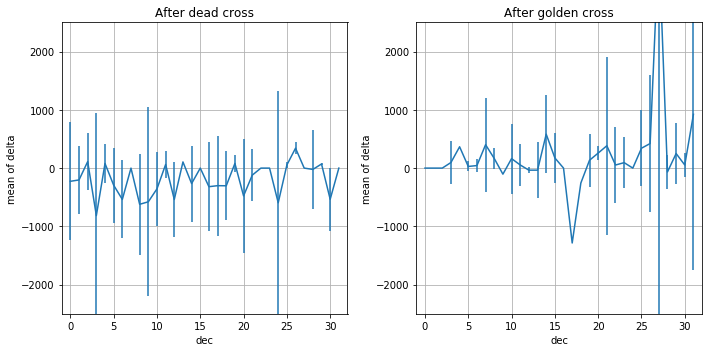

In [7]:
stat_dead = results["stat_dead"]
stat_golden = results["stat_golden"]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.errorbar(np.arange(2**N_dec), stat_dead[:, 2], yerr=stat_dead[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.subplot(122)
plt.errorbar(np.arange(2**N_dec), stat_golden[:, 2], yerr=stat_golden[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.tight_layout()

In [30]:
threshold = 0
dead_plus = np.arange(2**N_dec)[stat_dead[:, 2] < -threshold]
golden_plus = np.arange(2**N_dec)[stat_golden[:, 2] > threshold]
dead_plus, golden_plus

(array([ 0,  1,  3,  5,  6,  8,  9, 10, 12, 14, 16, 17, 18, 20, 21, 24, 28,
        30]),
 array([ 3,  4,  5,  6,  7,  8, 10, 11, 14, 15, 19, 20, 21, 22, 23, 25, 26,
        27, 29, 30, 31]))

## 箱ひげ図のプロット

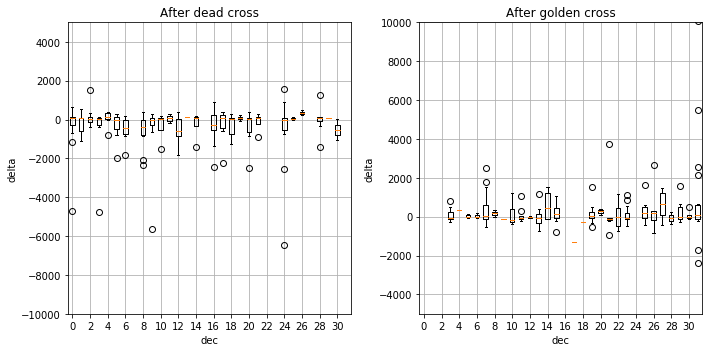

In [6]:
list_ext_dead = results["list_ext_dead"]
list_ext_golden = results["list_ext_golden"]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.boxplot(tuple(list_ext_dead))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After dead cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-10000, 5000)
plt.grid(True)

plt.subplot(122)
plt.boxplot(tuple(list_ext_golden))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After golden cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-5000, 10000)
plt.grid(True)

plt.tight_layout()

## 特定のパターンでのみ注文

In [36]:
st = time.time()
for threshold in range(0, 500, 10):
    dead_plus = np.arange(2**N_dec)[stat_dead[:, 2] < -threshold]
    golden_plus = np.arange(2**N_dec)[stat_golden[:, 2] > threshold]
    results = main(df, N1, N2, N_dec, golden_plus, dead_plus)
    benefits = results["benefits"]
    a_k = results["a_k"]
    print(threshold, -benefits[a_k[:, 1] == -1].sum() + benefits[a_k[:, 1] == 1].sum())
print(time.time() - st)

0 133592
10 133592
20 133592
30 133326
40 133326
50 133196
60 131918
70 131918
80 131918
90 131918
100 129939
110 129939
120 129939
130 129454
140 127567
150 127567
160 127567
170 126423
180 123806
190 123806
200 123806
210 122790
220 122790
230 117352
240 117352
250 114604
260 113831
270 112770
280 112770
290 112770
300 109837
310 105906
320 100483
330 100483
340 100483
350 98437
360 96657
370 96291
380 96291
390 93990
400 93990
410 86766
420 86766
430 84658
440 84658
450 84658
460 84658
470 84658
480 81798
490 81798
41.684778928756714


平均的にゼロより大きなものだけをピックアップすれば少しでも上げられる様子。

## まとめ
* 平均値がゼロより大きい場合のに注文を出すとよりプラスになる。